# 0.0 - Problema de Negócio

- Id: identificador único do cliente.
- Gender: gênero do cliente.
- Age: idade do cliente.
- Driving License: 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira Nacional de Habilitação )
- Region Code: código da região do cliente.
- Previously Insured: 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
- Vehicle Age: idade do veículo.
- Vehicle Damage: 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.
- Anual Premium: quantidade que o cliente pagou à empresa pelo seguro de saúde anual.
- Policy sales channel: código anônimo para o canal de contato com o cliente.
- Vintage: número de dias que o cliente se associou à empresa através da compra do seguro de saúde.
- Response: 0, o cliente não tem interesse e 1, o cliente tem interesse.

# 1.0 - Importações e Funções

In [1]:
import pandas                  as pd
import seaborn                 as sns
import matplotlib.pyplot       as plt
import numpy                   as np
import scikitplot              as skplt

from IPython.display           import Image
from xgboost                   import XGBClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.dummy             import DummyClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble          import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics           import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score
from sklearn.preprocessing     import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.under_sampling   import NearMiss
from sklearn.model_selection   import train_test_split
from imblearn.over_sampling    import SMOTE 
from sklearn.svm               import SVC


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Função para criar range de idades para visualizar melhor graficamente.
def age_range(age):
    if age < 31:
        return 1
    elif age >= 31 and age < 42:
        return 2
    elif age >= 42 and age < 53:
        return 3
    elif age >= 53 and age < 64:
        return 4
    elif age >= 64 and age < 75:
        return 5
    else: 
        return 6
        

In [3]:
# Função para criar range de valor pago para visualizar melhor graficamente.
def annual_premmium_range(valor):
    if valor < 100000:
        return 1
    elif valor >= 100000 and valor < 200000 :
        return 2
    elif valor >= 200000 and valor < 300000:
        return 3
    elif valor >= 300000 and valor < 400000:
        return 4
    elif valor >= 400000 and valor < 500000:
        return 5
    else: 
        return 6
        

In [4]:
def cross_validation (modelo, model_name, X_train, y_train, k=10):
    
    precision = []
    recall = []
    
    X_l = X_train.values
    y_l = y_train.values
    
    for train, test in skf.split(X_l, y_l):

        X_train_cv, X_test_cv = X_l[train], X_l[test]
        y_train_cv, y_test_cv = y_l[train], y_l[test]
    
        modelo.fit(X_train_cv, y_train_cv)
        pred = modelo.predict_proba(X_test_cv)
    
        data = X_test_cv.copy()
        data = pd.DataFrame(data)
        
        data['response'] = y_test_cv.tolist()
        data['score'] = pred[:, 1].tolist()
        data = data.sort_values( 'score', ascending=False )
        data = data.reset_index( drop=True )
        data['ranking'] = data.index + 1 
        data['precision_at_k'] = data['response'].cumsum() / data['ranking']
        data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
        precision.append(data.loc[k, 'precision_at_k'])
        recall.append(data.loc[k, 'recall_at_k'])
    
    return pd.DataFrame( {'Model Name': model_name,
                        'Precision' : (np.mean(precision).round(2)),
                        'Recall': (np.mean(recall).round(4))}, index=[0])

# 2.0 -  Análise Descritiva 

In [5]:
df = pd.read_csv('train.csv')

In [6]:
df.sample(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
218819,218820,Female,29,1,35.0,1,< 1 Year,No,28775.0,152.0,288,0
331321,331322,Male,34,1,50.0,0,1-2 Year,Yes,35498.0,16.0,173,0
365073,365074,Male,20,1,28.0,0,1-2 Year,No,2630.0,157.0,78,0
73868,73869,Female,61,1,28.0,0,> 2 Years,Yes,74730.0,26.0,263,0
94194,94195,Male,37,1,20.0,1,1-2 Year,No,2630.0,124.0,258,0


## 2.1 - Data Shape

In [7]:
df.shape

(381109, 12)

## 2.2 - Data Info

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 2.3 - Data Describe

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


# 3.0 - Feature Enginnering 

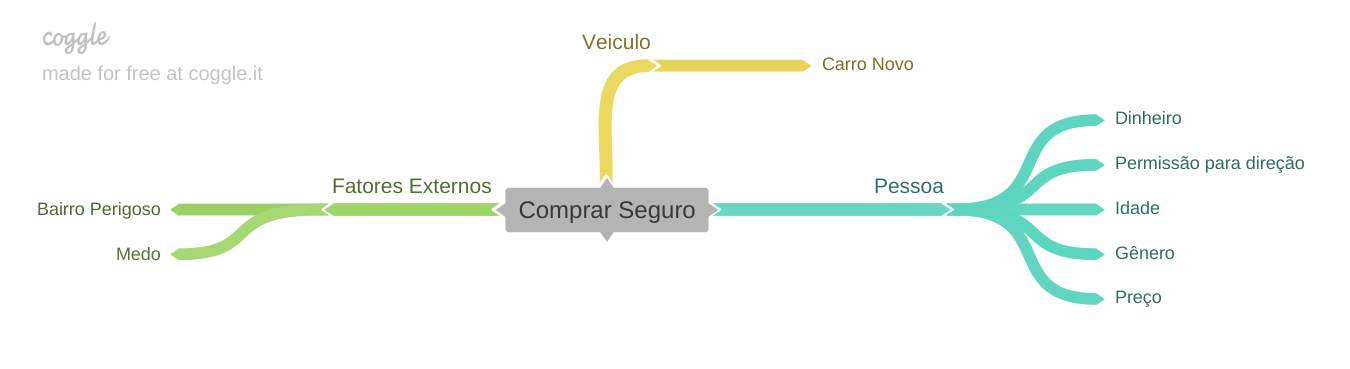

In [10]:
Image ('Comprar_Seguro.png')

## 3.1 - Criação das Hipóteses

**Hipótese do Veículo**

**1.** Clientes com carros mais novos tem mais propensão a comprar seguro.

**Hipótese da Pessoa**

**1.** Clientes que pagam um valor mais alto de seguro de vida tem mais propensão a comprar o seguro.<br/>
**2.** Clientes com mais idade tem mais propensão a comprar o seguro.<br/>
**3.** Homens tem mais propensão a comprar o seguro.<br/>
**4.** Clientes que tem carta de motorista tem mais propensão a comprar o seguro.<br/>
**5.** Cliente que já tiveram o carro danificado no passado tem mais propensão a comprar o seguro.

## 3.2 - Feature Engineering

In [11]:
df['DrivingLicense_PreviouslyInsured'] = df['Driving_License']+df['Previously_Insured']

df['Age_Range'] = df['Age'].apply(age_range)

df['Annual_Premium_range'] = df['Annual_Premium'].apply(annual_premmium_range)

## 3.3 Separação de variavéis númericas e categoricas

In [12]:
df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')

# 4.0 - Análise Exploratória

## 4.1 - Análise univariada

### 4.1.1 - Variável Resposta

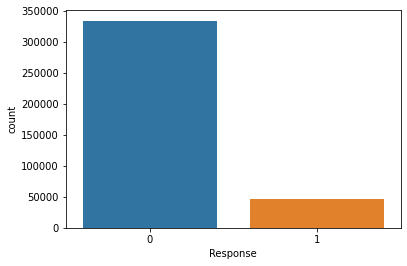

In [13]:
# Os dados estão desbalanceados. A grande maioria não tem interesse em efetuar a compra do seguro.
sns.countplot(x='Response', data=df);

### 4.1.2 - Variáveis númericas

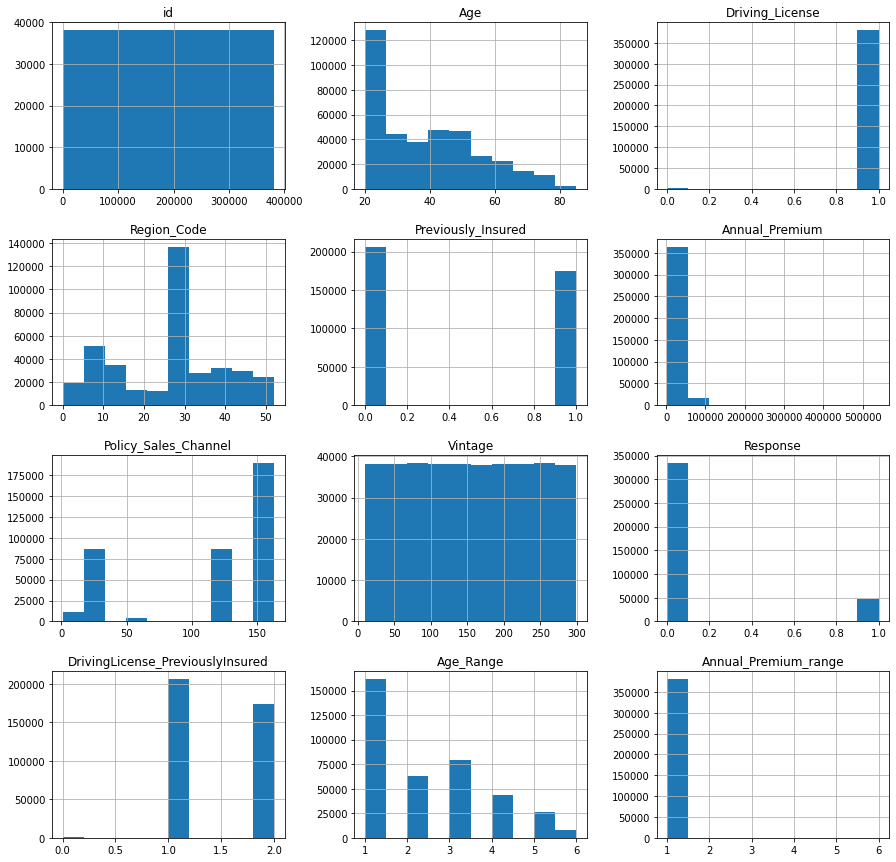

In [14]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
df_num.hist(ax=ax);

### 4.1.3 - Variáveis Categoricas

In [15]:
df_cat.apply(lambda x: x.unique())

Gender                             [Male, Female]
Vehicle_Age       [> 2 Years, 1-2 Year, < 1 Year]
Vehicle_Damage                          [Yes, No]
dtype: object

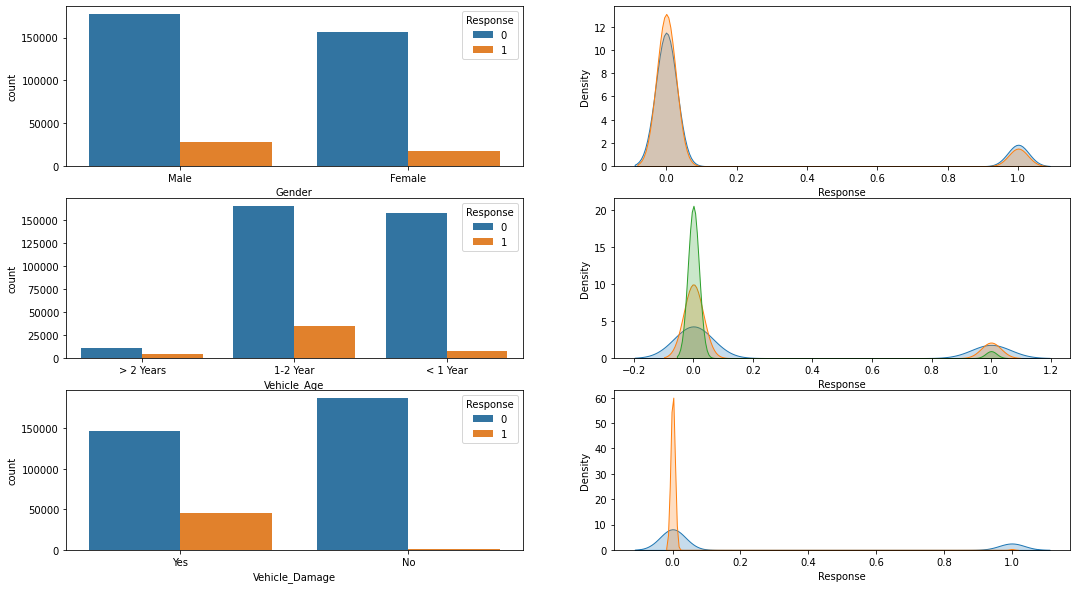

In [16]:
plt.figure(figsize=(18,10))
plt.subplot(3,2,1)
sns.countplot(x='Gender', hue='Response', data=df)

plt.subplot(3,2,2)
sns.kdeplot(df[df['Gender'] == 'Male']['Response'],label='Male', shade=True)
sns.kdeplot(df[df['Gender'] == 'Female']['Response'], label='Female', shade=True)

plt.subplot(3,2,3)
sns.countplot(x='Vehicle_Age', hue='Response', data=df)

plt.subplot(3,2,4)
sns.kdeplot(df[df['Vehicle_Age'] == '> 2 Years']['Response'],label='> 2 Years', shade=True)
sns.kdeplot(df[df['Vehicle_Age'] == '1-2 Year']['Response'], label='1-2 Year', shade=True)
sns.kdeplot(df[df['Vehicle_Age'] == '< 1 Year']['Response'], label='< 1 Year', shade=True)

plt.subplot(3,2,5)
sns.countplot(x='Vehicle_Damage', hue='Response', data=df)

plt.subplot(3,2,6)
sns.kdeplot(df[df['Vehicle_Damage'] == 'Yes']['Response'], label='Yes', shade=True)
sns.kdeplot(df[df['Vehicle_Damage'] == 'No']['Response'],  label='No', shade=True);

## 4.2 - Análise Bivariada

**H1 - Os clientes que possuem os carros mais novos são mais interessados em seguro?**

**R:** Falso. Em média os clientes que possuem carros com mais de dois anos tem mais interesse em comprar o seguro.

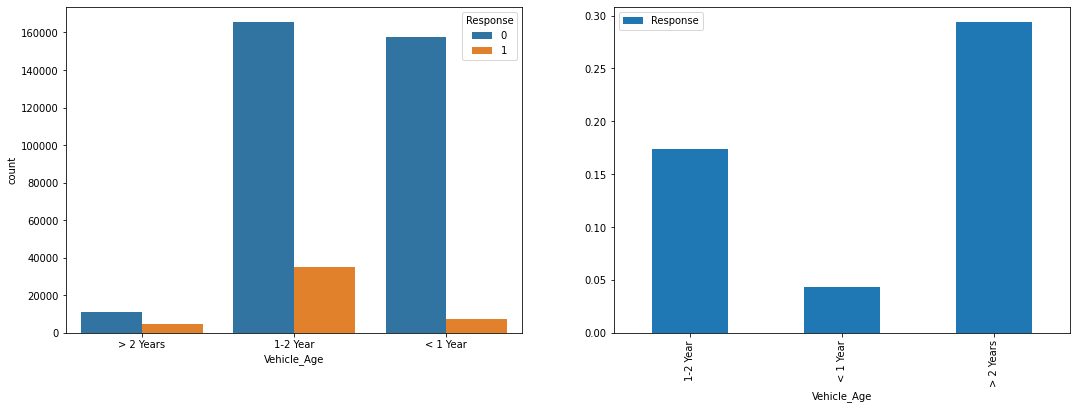

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Vehicle_Age', hue='Response', data=df, ax=ax[0]);

aux1 = df[['Vehicle_Age', 'Response']].groupby('Vehicle_Age').mean();
aux1.plot.bar(ax=ax[1]);


**H2 - Clientes que pagam um valor mais alto de seguro de vida tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. Em média, clientes que pagam de 400 mil a 500 mil são os mais interessados em comprar o seguro.

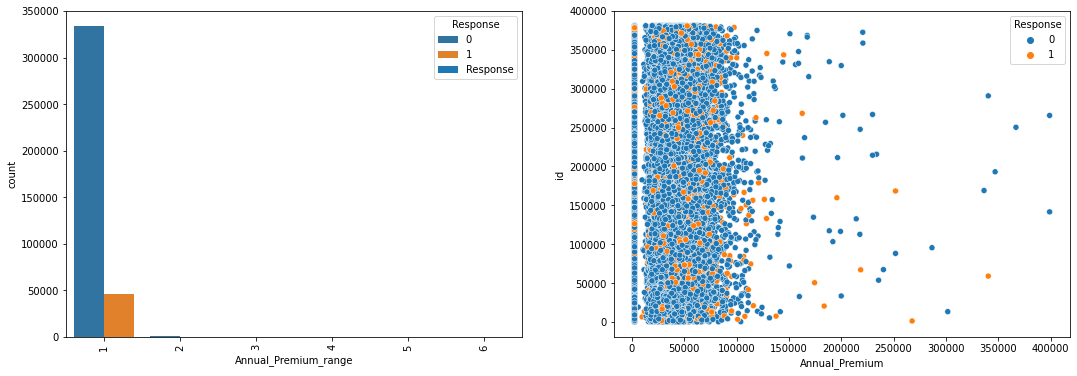

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
sns.countplot(x='Annual_Premium_range', hue='Response', data=df,ax=ax[0])

aux1 = df[['Annual_Premium_range', 'Response']].groupby('Annual_Premium_range').mean()
aux1.plot.bar(ax=ax[0]);

aux2 = df.sample(100000)
sns.scatterplot(x='Annual_Premium', y='id', hue='Response', data=aux2,ax=ax[1]);

**H3 - Clientes com mais idade tem mais propensão a comprar o seguro.**

**R:** Falso. Em média os clientes de meia idade tem mais interesse em comprar o seguro.

**Qual idade que contrata mais seguro?**

**R:** As pessoas mais jovens (até 30 anos)são mais acostumadas a contratar seguro.

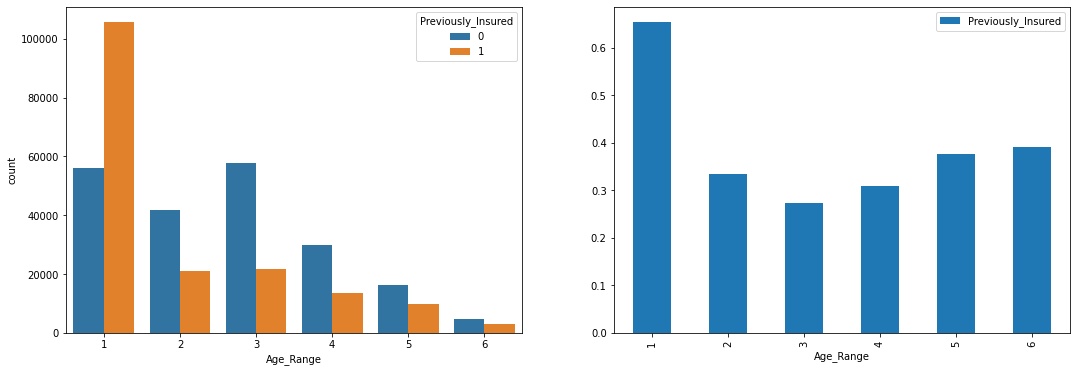

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Age_Range', hue='Previously_Insured', data=df, ax=ax[0]);

aux1 = df[['Age_Range', 'Previously_Insured']].groupby('Age_Range').mean();
aux1.plot.bar(ax=ax[1]);

**Qual idade está mais propensa a comprar o seguro?**

**R:** Em média, quem está no Age_Range 2 e 3 (de 31 até 53 anos) tem mais propensão a contratar um seguro.

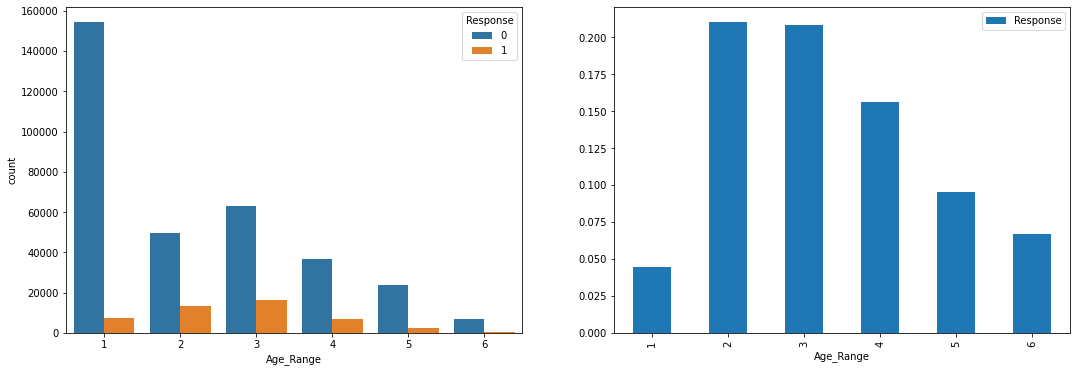

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Age_Range', hue='Response', data=df, ax=ax[0]);

aux1 = df[['Age_Range', 'Response']].groupby('Age_Range').mean()
aux1.plot.bar(ax=ax[1]);

**H4 - Homens tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. Em média os clientes do gênero Masculino possuem interesse em comprar o seguro do que o gênero feminino.

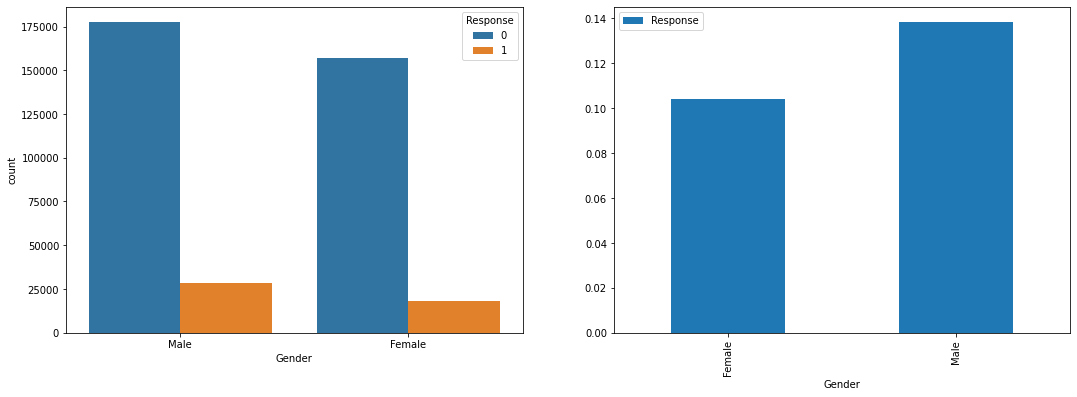

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Gender', hue='Response', data=df, ax=ax[0]);

aux1 = df[['Gender', 'Response']].groupby('Gender').mean();
aux1.plot.bar(ax=ax[1]);


**H5 - Clientes que tem carta de motorista tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. A grande maioria das pessoas da amostra possui carteira de habilitação. Porém, é grande o número de pessoas que não possuem carta e tem interesse em contratar o seguro.

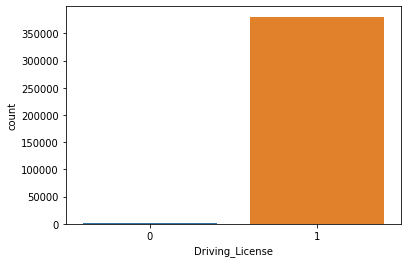

In [22]:
sns.countplot(x='Driving_License', data=df);

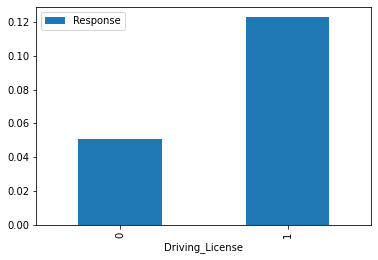

In [23]:
aux1 = df[['Driving_License', 'Response']].groupby('Driving_License').mean();
aux1.plot.bar();


**H6 - Cliente que já tiveram o carro danificado no passado tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. Clientes que já sofreram acidentes contrataram muito mais o seguro.

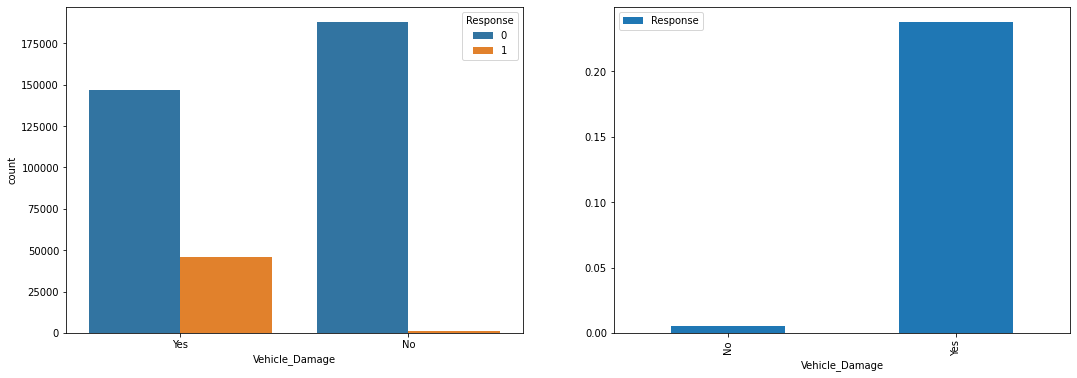

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Vehicle_Damage',hue='Response', data=df, ax=ax[0])

aux1=df[['Vehicle_Damage', 'Response']].groupby('Vehicle_Damage').mean();
aux1.plot.bar(ax=ax[1]);

 <h1>Mais Hipóteses<h1>

**Quem esta mais propenso a contratar? Quem já tem seguro ou quem ainda não tem?**

**R:** Aparentemente as pessoas que ainda não tem seguro são mais interessadas em contratar do que as pessoas que já tem.

- A porcentagem de pessoas que não tem seguro e contratariam seguro  é 23%
- A porcentagem de pessoas que ja tem seguro e contratariam outro é 0.09%

O total de pessoas que já tem seguro e não estariam interessadas em contratar outro seguro é:  174470
O total de pessoas que já tem seguro e estariam interessadas interessadas em contratar outro seguro é:  158
-----------------------------------------------------------------------------
O total de pessoas que não tem seguro e não estariam interessada em ter seguro é:  159929
O total de pessoas que não tem seguro e estariam interessadas em contratar seguro é:  46552
-----------------------------------------------------------------------------


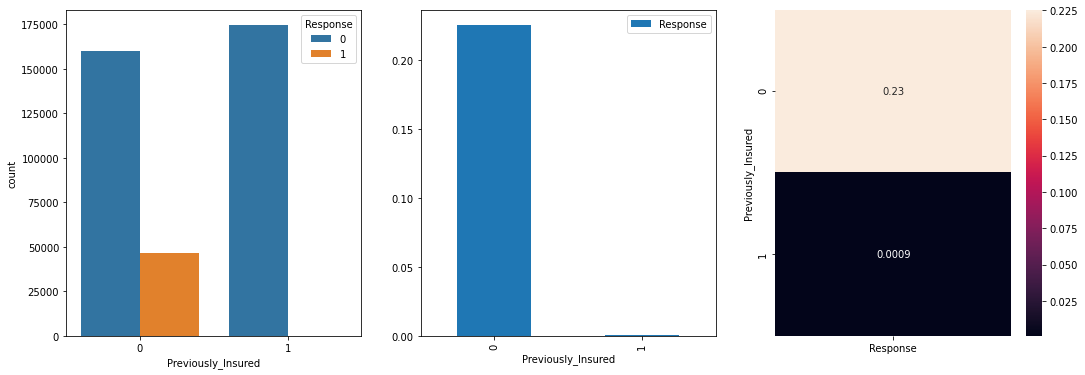

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

sns.countplot(x='Previously_Insured', hue='Response', data=df, ax=ax[0]);

print("O total de pessoas que já tem seguro e não estariam interessadas em contratar outro seguro é: ",
df[(df['Previously_Insured']==1) & (df['Response']==0)].shape[0])

print("O total de pessoas que já tem seguro e estariam interessadas interessadas em contratar outro seguro é: ",
df[(df['Previously_Insured']==1) & (df['Response']==1)].shape[0])

print("-----------------------------------------------------------------------------")

print("O total de pessoas que não tem seguro e não estariam interessada em ter seguro é: ",
df[(df['Previously_Insured']==0) & (df['Response']==0)].shape[0])

print("O total de pessoas que não tem seguro e estariam interessadas em contratar seguro é: ",
df[(df['Previously_Insured']==0) & (df['Response']==1)].shape[0])

print("-----------------------------------------------------------------------------")

aux1 = df[['Previously_Insured', 'Response']].groupby('Previously_Insured').mean();
aux1.plot.bar(ax=ax[1]);

sns.heatmap(aux1, annot=True, ax=ax[2]);

**Qual região possui mais clientes em nossa amostra?**

**R:** A Região 28 é a região que mais possui clientes em nossa amostra.

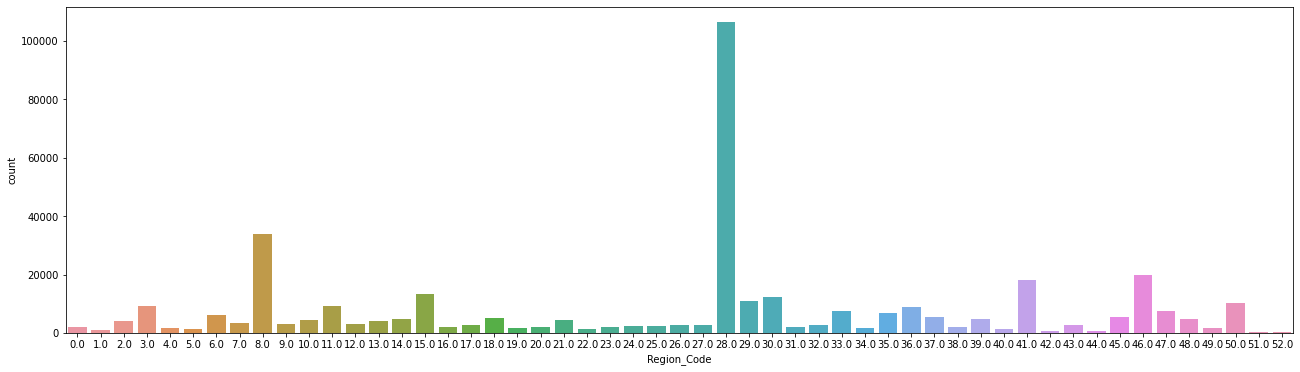

In [26]:
plt.figure(figsize=(22,6))
sns.countplot(x='Region_Code', data=df);

## 4.3 - Análise Multivariada

### Variavéis Númericas

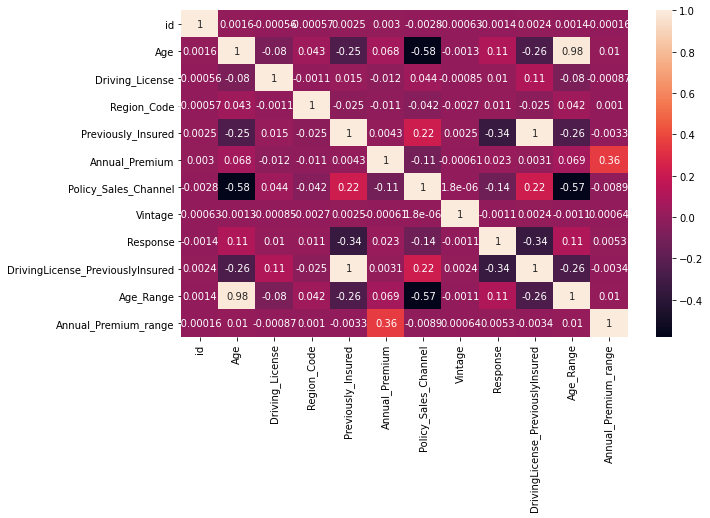

In [27]:
correlation = df_num.corr(method='pearson')
plt.figure(figsize=(10,6))
sns.heatmap(correlation, annot=True);

# 5.0 - Preparação dos Dados

In [28]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response',
       'DrivingLicense_PreviouslyInsured', 'Age_Range',
       'Annual_Premium_range'],
      dtype='object')

In [29]:
# deletando as variavéis que criei para ajudar nos gráficos
df = df.drop(['Age_Range', 'Annual_Premium_range'], axis=1)

In [30]:
X = df.drop(['Response'], axis=1)
y = df['Response']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [32]:
df2 = pd.concat( [X_train, y_train], axis=1 )

## Standardization

In [33]:
ss_annual_premium = StandardScaler()

df2['Annual_Premium'] = ss_annual_premium.fit_transform(df2[['Annual_Premium']].values)

## Rescalling

In [34]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

df2['Age'] = mms_age.fit_transform(df2[['Age']].values)

df2['Vintage'] = mms_vintage.fit_transform(df2[['Vintage']].values)

## Encoder

In [35]:
#region_code
target_encode_region_code = df.groupby('Region_Code')['Response'].mean()
df2.loc[:, 'Region_Code'] = df2['Region_Code'].map(target_encode_region_code)

#vehicle_age
df2 = pd.get_dummies(df2, prefix='Vehicle_Age', columns=['Vehicle_Age'])
df2 = pd.get_dummies(df2, prefix='Gender', columns=['Gender'])
df2 = pd.get_dummies(df2, prefix='Vehicle_Damage', columns=['Vehicle_Damage'])
df2 = pd.get_dummies(df2, prefix='DrivingLicense_PreviouslyInsured', columns=['DrivingLicense_PreviouslyInsured'])

# Policy_sales_channel
target_encode_policy_sales_channel = df.groupby('Policy_Sales_Channel')['Response'].mean()
df2.loc[:, 'Policy_Sales_Channel'] = df2['Policy_Sales_Channel'].map(target_encode_policy_sales_channel)

In [36]:
X_test = pd.get_dummies( X_test, prefix='Gender', columns=['Gender'] )

X_test.loc[:, 'Age'] = mms_age.transform(X_test[['Age']].values )

X_test.loc[:, 'Region_Code'] = X_test.loc[:, 'Region_Code'].map( target_encode_region_code )

X_test = pd.get_dummies( X_test, prefix='Vehicle_Age', columns=['Vehicle_Age'] )

X_test = pd.get_dummies( X_test, prefix='Vehicle_Damage', columns=['Vehicle_Damage'] )

X_test.loc[:, 'Annual_Premium'] = ss_annual_premium.transform( X_test[['Annual_Premium']].values )

X_test.loc[:, 'Policy_Sales_Channel'] = X_test['Policy_Sales_Channel'].map(target_encode_policy_sales_channel)

X_test.loc[:, 'Vintage'] = mms_vintage.transform( X_test[['Vintage']].values )

## Conferindo Data

In [37]:
df2.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Gender_Female,Gender_Male,Vehicle_Damage_No,Vehicle_Damage_Yes,DrivingLicense_PreviouslyInsured_0,DrivingLicense_PreviouslyInsured_1,DrivingLicense_PreviouslyInsured_2
274710,274711,0.030769,1,0.118147,0,-0.297943,0.028624,0.667820,0,0,1,0,0,1,0,1,0,1,0
216539,216540,0.092308,1,0.096142,1,0.452554,0.199385,0.121107,0,0,1,0,1,0,1,0,0,0,1
78983,78984,0.184615,1,0.187163,0,0.088559,0.173212,0.086505,1,0,1,0,1,0,0,1,0,1,0
218368,218369,0.184615,1,0.079258,0,0.412993,0.028624,0.709343,0,0,1,0,0,1,0,1,0,1,0
307215,307216,0.061538,1,0.187163,0,1.050781,0.215458,0.733564,0,0,1,0,1,0,0,1,0,1,0


# 6.0 - Feature Selection

### Feature Importance

In [38]:
X_train_n = df2.drop( ['Response', 'id'], axis=1 )
y_train_n = df2['Response']

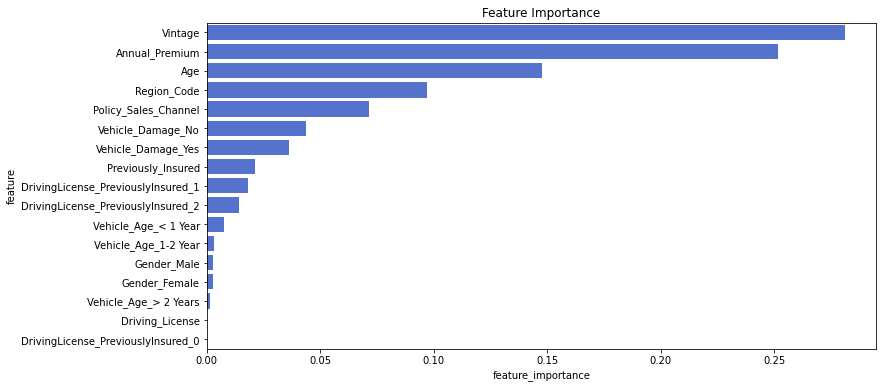

In [39]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_n, y_train_n)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train_n.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

In [40]:
X_train_f = X_train_n[['Vintage', 'Annual_Premium', 'Region_Code', 'Age', 
             'Policy_Sales_Channel', 'Vehicle_Damage_Yes', 'Vehicle_Damage_No']]

X_test_f = X_test[['Vintage', 'Annual_Premium', 'Region_Code', 'Age', 
             'Policy_Sales_Channel', 'Vehicle_Damage_Yes', 'Vehicle_Damage_No']]

# 6.0 - Machine Learning

In [41]:
du = DummyClassifier()
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
etx = ExtraTreesClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
xbc = XGBClassifier(eval_metric = 'error')
knn = KNeighborsClassifier()
ada = AdaBoostClassifier()
svm = SVC()

In [42]:
skf = StratifiedKFold(n_splits=5)

## DummyClassifier

In [43]:
du_result = cross_validation (du,'Dummy', X_train_f, y_train, k=50)

## Regressão Logística

In [44]:
lr_result = cross_validation(lr, 'Logistic Regression', X_train_f, y_train, k=50)

## DecisionTreeClassifier

In [45]:
dtc_result = cross_validation(dtc, 'Decision Tree Classifier', X_train_f, y_train, k=50)

## ExtraTreesClassifier

In [46]:
etx_result = cross_validation(etx, 'Extra Trees Classifier', X_train_f, y_train, k=50)

## RandomForestClassifier

In [47]:
rfc_result = cross_validation(rfc, 'Randon Forest Classifier', X_train_f, y_train, k=50)

## GradientBoostingClassifier

In [48]:
gbc_result = cross_validation(gbc, 'Gradient Boosting Classifier', X_train_f, y_train, k=50)

## XGBClassifier

In [49]:
xgb_result = cross_validation(xbc, 'XGB Classifier', X_train_f, y_train, k=50)

## AdaBoost

In [50]:
ada_result = cross_validation(ada, 'AdaBoost Classifier', X_train_f, y_train, k=50)

In [51]:
knn_result = cross_validation(knn, 'KNN', X_train_f, y_train, k=50)

In [52]:
modelling_result = pd.concat([du_result, lr_result, etx_result, dtc_result, rfc_result,
                             gbc_result, xgb_result, ada_result, knn_result])
modelling_result.sort_values('Precision', ascending=False)

,Model Name,Precision,Recall
0,Gradient Boosting Classifier,0.51,0.0035
0,AdaBoost Classifier,0.45,0.0031
0,XGB Classifier,0.43,0.0029
0,KNN,0.38,0.0026
0,Randon Forest Classifier,0.36,0.0025
0,Decision Tree Classifier,0.32,0.0022
0,Logistic Regression,0.29,0.0020
0,Extra Trees Classifier,0.29,0.0020
0,Dummy,0.11,0.0008


In [53]:
gbc.fit(X_train_f, y_train)

GradientBoostingClassifier()

In [54]:
pred_gbc = gbc.predict_proba(X_test_f)

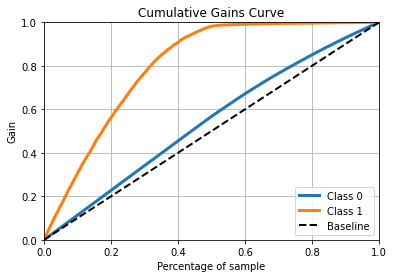

In [55]:
skplt.metrics.plot_cumulative_gain(y_test, pred_gbc);

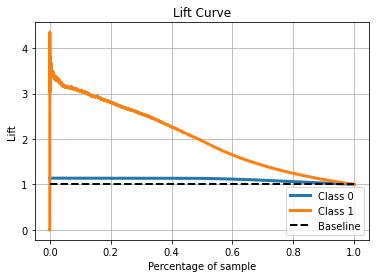

In [56]:
skplt.metrics.plot_lift_curve(y_test, pred_gbc);